In [1]:
#!g1.1
import warnings
import datetime
import os
import functools as ft
import json
import cv2
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import pandas as pd
import numpy as np
from torchvision import transforms 
from torchvision.utils import draw_bounding_boxes
from PIL import Image
from matplotlib import pyplot as plt
import torchvision.transforms.functional as F
from torchvision.ops import batched_nms
from tqdm import tqdm

from config import INPUT_DIR, PATH_TO_MODEL_WEIGHTS, PREPROCESSED_DATAFRAME, DEVICE


#!g1.1
def draw_and_save_results(sample, bb_dict, output_dir, image_id, mode, conf_threshold=0, iou_threshold=0):
    """Отрисовка и сохранение изображений и боксов.
    
    input:
        sample - изображение в виде тензора;
        bb_dict - словарь данных вида: {'boxes': координаты боксов, 'labels': метки классов, 'scores': confidence};
        output_dir - название директории, в которую будут сохраняться результаты;
        image_id - название изображения, которое соответствует его id;
        mode {'ture', 'confidence', 'nms'} - режим применения функции для учета соотв.-х названий файлов и директорий;
        conf_threshold - порог confidence, по которому отсеиваются мусорные боксы;
        iou_threshold - порог IoU, по которому non-max-suppression работает для оставшихся боксов (отдельно для каждого класса).
    
    return: ничего не возвращает.
    """

    image_and_result = draw_bounding_boxes(torch.tensor(sample*255, dtype=torch.uint8), bb_dict['boxes'], 
                                           colors = ['yellow' if l == 1 else 'blue' for l in bb_dict['labels'].cpu().numpy()],
                                           labels = ['signature' if l == 1 else 'stamp' for l in bb_dict['labels'].cpu().numpy()],
                                           width=5,
                                           fill = True,
                                           font_size = 70)

    grid = torchvision.utils.make_grid(image_and_result)
    ndarr = grid.clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    im = Image.fromarray(ndarr)

    os.makedirs(ft.reduce(os.path.join, ['predicts', output_dir]), exist_ok=True)

    if mode == 'confidence':
        os.makedirs(ft.reduce(os.path.join, ['predicts', output_dir, 'predict_with_threshold']), exist_ok=True)
        im.save(ft.reduce(os.path.join, ['predicts', output_dir, 'predict_with_threshold', 'thrsh_{}.png'.format(image_id)]))
        show(image_and_result, name='Изображение: {}, после установки confidence_threshold={}'.format(image_id, conf_threshold))
        
    elif mode == 'nms':
        os.makedirs(ft.reduce(os.path.join, ['predicts', output_dir, 'predict_with_nms']), exist_ok=True)
        im.save(ft.reduce(os.path.join, ['predicts', output_dir, 'predict_with_nms', 'nms_{}.png'.format(image_id)])) 
        show(image_and_result, name='Изображение: {}, после применения non-max-suppression (IoU={})'.format(image_id, iou_threshold))
        
    else:
        os.makedirs(ft.reduce(os.path.join, ['predicts', output_dir, 'true_result']), exist_ok=True)
        im.save(ft.reduce(os.path.join, ['predicts', output_dir, 'true_result', 'true_{}.png'.format(image_id)]))
        show(image_and_result, name='Изображение: {}, целевые боксы'.format(image_id))


        
def show(imgs, name=None):
    """Отрисовка документа."""
    
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize = (15,15))
    plt.gca().set_title(name, fontsize=18)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
        
def get_date():
    """Текущая дата.

    return: строку с текущей датой в формате '%d.%m.%Y_%H_%M_%S'.
    """
    t = datetime.datetime.now().timetuple()
    return '{:02d}.{:02d}.{:02d}_{:02d}_{:02d}_{:02d}'.format(*[t[x] for x in [2, 1, 0, 3, 4, 5]])


def make_predict(model, df, image_id, input_dir, confidence_threshold, nms_iou_threshold, number_of_input_images):
    global output_dir, end_of_calculation
    
    """Получение предсказанных моделью боксов.
    
    input:
        model - обученная модель;
        df - датафрейм, содержащий изображения, на которых будут предсказаны боксы (test_df);
        image_id - название изображения, которое соответствует его id;
        input_dir - путь к директории, в которой находятся train-, validate- и test- датасеты;
        confidence_threshold - порог confidence, по которому отсеиваются мусорные боксы;
        nms_iou_threshold - порог IoU, по которому non-max-suppression работает для оставшихся боксов (отдельно для каждого класса);
        number_of_input_images - число входных изображений. 
    
    global:
        output_dir - название директории, в которую будут сохраняться результаты;
        end_of_calculation {True, False} - закончился текущий рассчет или нет. 
    
    return:
        dict_true - словарь данных* о целевых боксах;
        dict_predict - словарь данных* о  боксах, оставшихся после фильтрации по confidence;
        predict_nms - словарь данных* о боксах, оставшихся после фильтрации по confidence и применения алгоритма non-max-suppression;
        predict_nms_array - словарь predict_nms в формате для записи в файл;
        output_dir - словарь данных о целевых боксах.
        
        * - {'boxes': координаты боксов, 'labels': метки классов, 'scores': confidence}.
    """
    # Создание новой директории для сохранения результатов (если расчет начался заново)
    if end_of_calculation == number_of_input_images:
        output_dir = '{}_conf:{}_nms:{}'.format(get_date(), confidence_threshold, nms_iou_threshold)
    
    # Загрузка изображения
    image = cv2.imread(ft.reduce(os.path.join, [input_dir, image_id]), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image = trans(image)
    sample = image.cpu()
    
    # Создание словаря dict_true из целевых боксов и меток
    records = df[df['image_id'] == image_id]   
    true_boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
    true_boxes = torch.as_tensor(true_boxes, dtype=torch.float32)
    true_labels = records['labels'].values
    true_labels = torch.as_tensor(true_labels, dtype=torch.int64)
    dict_true = {}
    dict_true['boxes'] = true_boxes
    dict_true['labels'] = true_labels
    dict_true['image_id'] = image_id
    
    # Отрисовка и сохранение изображения с целевыми боксами
    draw_and_save_results(sample, dict_true, output_dir, image_id, 'ture')
    
    # Получение предсказаний
    predict = model([sample])
    
    # Фильтрация мусорных боксов(меток и скоров) по значению порога confidence_threshold
    boxes = predict[0]['boxes'][predict[0]['scores'] > confidence_threshold]
    labels = predict[0]['labels'][predict[0]['scores'] > confidence_threshold]
    scores = predict[0]['scores'][predict[0]['scores'] > confidence_threshold]

    # Создание словаря dict_predict из предсказанных боксов и меток
    dict_predict = {}
    dict_predict['boxes'] = boxes
    dict_predict['labels'] = labels
    dict_predict['image_id'] = image_id
    dict_predict['scores'] = scores

    boxes = dict_predict['boxes'].cpu()
    sample = image.cpu()
    
    # Отрисовка и сохранение изображения с предсказанными боксами
    draw_and_save_results(sample, dict_predict, output_dir, image_id, 'confidence', conf_threshold=confidence_threshold)
    
    # Отсеивание повторных детекций с помощью алгоритма non-max-suppression (с учетом разных классов)
    indexes_nms = batched_nms(boxes, scores, labels, nms_iou_threshold)

    # Создание словаря с результатами после применения non-max-suppression
    predict_nms = {}
    predict_nms['boxes'] = torch.index_select(dict_predict['boxes'], 0, indexes_nms)
    predict_nms['labels'] = torch.index_select(dict_predict['labels'], 0, indexes_nms)
    predict_nms['scores'] = torch.index_select(dict_predict['scores'], 0, indexes_nms)

    # Отрисовка и сохранение изображения с оставшимися после применения non-max-suppression боксами 
    draw_and_save_results(sample, predict_nms, output_dir, image_id, 'nms', iou_threshold=nms_iou_threshold)
    
    # Конвертация результатов в формат для записи в файл
    predict_nms_array = {'boxes': predict_nms['boxes'].detach().numpy().tolist(),
                         'labels':  predict_nms['labels'].detach().numpy().tolist(),
                         'scores':  predict_nms['scores'].detach().numpy().tolist()}
    
    return dict_true, dict_predict, predict_nms, predict_nms_array, output_dir

In [2]:
#!g1.1
trans = transforms.Compose([transforms.ToTensor()]) 

# Загрузка тестового датасета
test_df = pd.read_csv(PREPROCESSED_DATAFRAME)

# Загрузка сохраненных весов модели
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load(ft.reduce(os.path.join, ['weights_of_models', PATH_TO_MODEL_WEIGHTS]),
                                 map_location=torch.device('cpu')))
model.eval()
model.to(torch.device('cpu'))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet50-0676ba61.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [4]:
#!g1.1
CONFIDENCE_THRESHOLD = 0.67
NMS_IOU_THRESHOLD = 0.25

In [15]:
#!g1.1
list_of_images

['1_1_423.jpg']

In [6]:
#!g1.1
INPUT_DIR

'/home/jupyter/mnt/datasets/SIGASTA/images'

In [ ]:
#!g1.1


100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


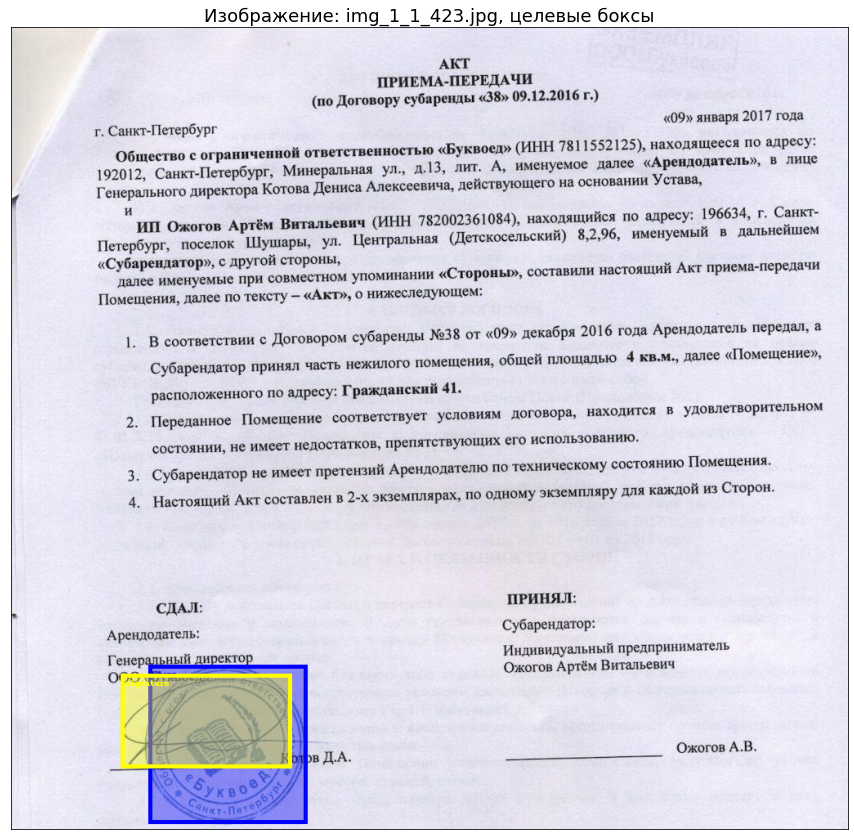

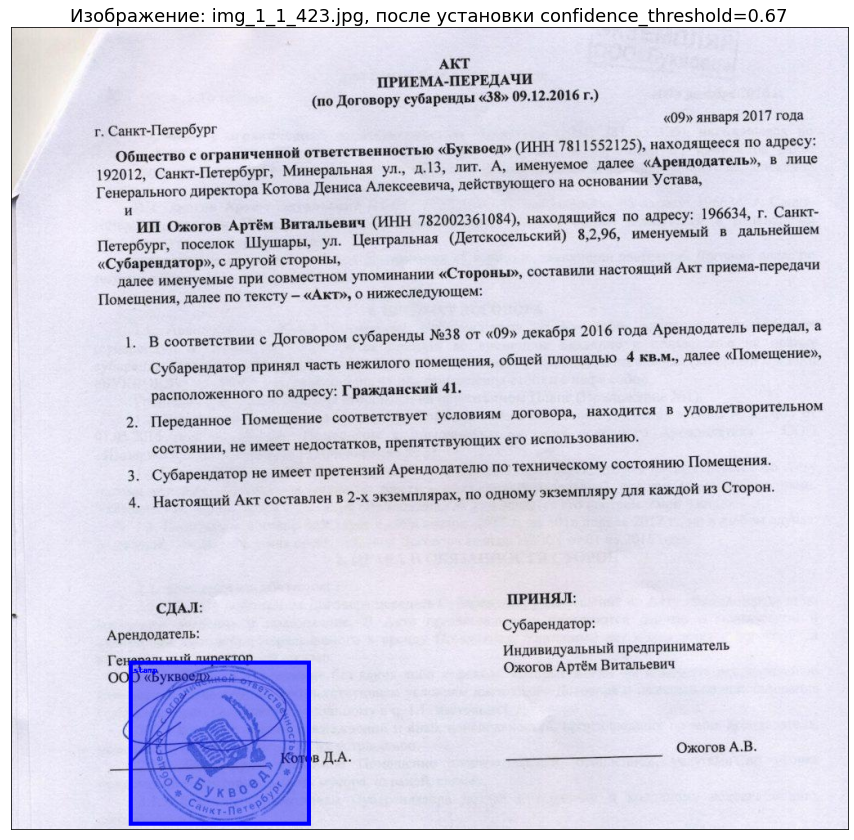

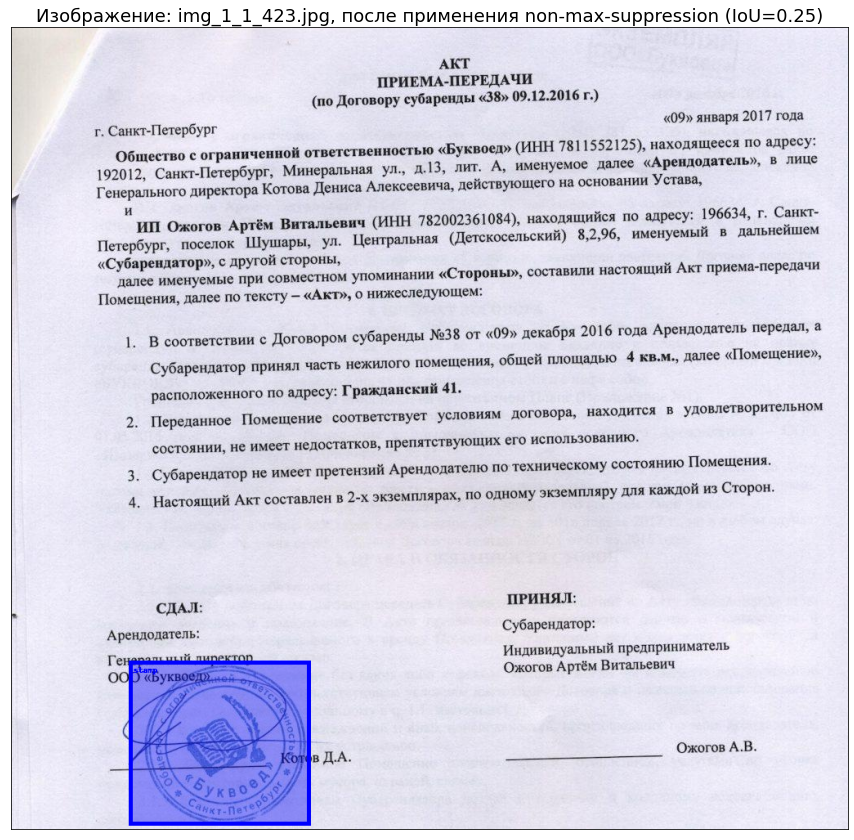

In [9]:
#!g1.1
warnings.filterwarnings('ignore')

# Детекция объектов на группе изображений
# list_of_images = list(test_df.image_id.unique())[0:30]
list_of_images = ['img_1_1_423.jpg']
end_of_calculation = len(list_of_images)
for i in tqdm(list_of_images):
    dict_true, dict_predict, dict_nms, dict_nms_arrays, output_dir = make_predict(model,
                                                                                  test_df,
                                                                                  i,
                                                                                  INPUT_DIR,
                                                                                  CONFIDENCE_THRESHOLD,
                                                                                  NMS_IOU_THRESHOLD,
                                                                                  len(list_of_images))
    res_dict = {'doc_name': i,
                'predict': dict_nms_arrays}
    
    os.makedirs(ft.reduce(os.path.join, ['json_results']), exist_ok=True)
    
    with open(ft.reduce(os.path.join, ['json_results', '{}.json'.format(output_dir)]), 'a+') as file:
        file.write(json.dumps(res_dict, sort_keys=True, indent=4))
    
    end_of_calculation -= 1

In [10]:
#!g1.1
dict_true

{'boxes': tensor([[168., 781., 362., 975.],
         [134., 792., 343., 907.]]),
 'labels': tensor([2, 1]),
 'image_id': 'img_1_1_423.jpg'}

In [11]:
#!g1.1
dict_nms

{'boxes': tensor([[144.7476, 776.8927, 366.8300, 977.3948]],
        grad_fn=<IndexSelectBackward>),
 'labels': tensor([2]),
 'scores': tensor([0.9637], grad_fn=<IndexSelectBackward>)}

In [13]:
#!g1.1
dict_true

{'boxes': tensor([[ 529., 1292.,  895., 1379.],
         [ 584., 1245.,  812., 1475.]]),
 'labels': tensor([1, 2]),
 'image_id': 'img_1_1_531.jpg'}

In [ ]:
#!g1.1
